# Artificial Neural Networks

Artifical neural networks (ANNs) are applied as a supervised learning technique to classify data into known classes.

![SegmentLocal](Images/curve_fit.png "curvefit")


\begin{align}
y & = W_1\,x4 + W_2\,x^3 + W_3\,x^2 + W_4\,x + W_5\\
\end{align}

You can think of them as a cousin of familiar regression or curve-fitting, but taken to higher dimensions. For example, when fitting a polynomial curve to a dataset we learn the values of the coefficients $W$ so that the model curve can accurately predict an outcome given input data. Similarly, for an ANN classifier, we learn a set of weights (coefficients) between the neurons so the the network can accurately predict a label for input data.

![SegmentLocal](Images/ANN_1layer.svg "ANN1")

In both cases the fitting procedure employs a measure of how well model performs. For curve fitting the distance between the data and model is minimised (e.g., $\chi^2$ or least-squared distance), while for an ANN classifier a *loss function* is minimised.

When training the classifier, the loss function desires the following state:

<img src="Images/loss_margin.jpg">

Scores inside the red region (or higher) will accumulate a loss, while scores below will accumulate zero loss.

## Stochastic Gradient Descent and mini-batches

Minimisation is done iteratively vis gradient descent:
 * Randomly initialise the weights between neurons
 * assess the performance of the network using the loss function
 * examine the slope of the loss surface and jump 'down-hill'
 * rinse and repeat until no improvement is seen

![SegmentLocal](Images/grad_descent.gif "descent")

This is superficially similar fitting a polynomial curve, however, there are two major differences:
 1. the weight coeefficients are not independent - the output of neurons are affected by all in the chain before them
 1. the very large datasets required by ANNs will not fit in memory
 
The first probem is addressed by back-probagating the gradients using the chain-rule. The second problem is solved by only training on a subset of the data, called a 'mini-batch' (or just 'batch'), and randomly changing the selection of this data every cycle.

## Implementing ANNs using Keras

In the last 10 years there has been an explosion in the availability of software for [deep learning](https://en.wikipedia.org/wiki/Comparison_of_deep-learning_software). One of the most popular is [Keras](https://keras.io/), which is a layer on top of Google's [TensorFlow](https://www.tensorflow.org/versions) machine learning and matrix manipulation library. (Alternatives are PyTorch, developed by Facebook, and CNTK by Microsoft). 

Performing the gradient descent step on even moderately large ANNs requires very intensive calculations. TensorFlow (and Keras) can take advantage of the parallel processing power offered by Graphics Processing Units (GPUs) to vastly accelerate the training step.


## Classifying handwriting - the MNIST dataset

Historically, one of the simplest tasks ANNs were applied to was handwriting recognition. In this notebook we will build an ANN to classify small images of handwritten digits [0 - 9]. This is a classic entry-level problem in machine learning.

The Modified National Institute of Standards and Technology (MNIST) dataset contains 60,000 training images and 10,000 testing images of handwritten digits as 28x28 pixel black & white images.

![SegmentLocal](Images/MNIST_grid.png "MNIST_grid")

These images are encoded with intensity values [0 - 255], so we usually scale them [0 - 1] by dividing by 255.0.

### Coding the classifier

Here we build a simple neural network classifier with two 'hidden layers'. The number of neurons in the *input layer* corresponds to each pixel of an image fed into the network. The number of neurons in the *output layer* corresponds to the possible classes.

![SegmentLocal](Images/ANN_2layers.png "ANN2")

For convenience the MNIST data is stored on disk as a Numpy save file containing a 3D array (images) or 1D array (labels 0 - 9). It is small enough to fit into memory. In this case, the data is already split into training ans tets sets.

In [1]:
import numpy as np

# Load the training images and labels from Numpy save files
trainX = np.load('DATA/minimnist/train_images.npy')
trainY = np.load('DATA/minimnist/train_labels.npy')
print("Training array shape:", trainX.shape)
print("Labels shape", trainY.shape)

Training array shape: (20000, 28, 28)
Labels shape (20000,)


In [2]:
# Load the testing images and labels from Numpy save files
testX = np.load('DATA/minimnist/test_images.npy')
testY = np.load('DATA/minimnist/test_labels.npy')
print("Training array shape:", testX.shape)
print("Labels shape", testY.shape)

Training array shape: (5000, 28, 28)
Labels shape (5000,)


Let's plot an individual image and display some statistics of the inetensity:

Min intensity =  0
Max intensity =  255
Image label =  7
Encoding =  uint8


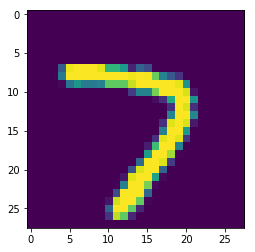

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Show a randomly chosen image
img = testX[17,:,:]
plt.imshow(img)

# Determine some stats and print
print("Min intensity = ", np.nanmin(img))
print("Max intensity = ", np.nanmax(img))
print("Image label = ", testY[17])
print("Encoding = ", img.dtype)

Both the training and test data should be converted into floating point precision and scaled into the range [0 - 1]. Machine learning algorithms tend to expect data in this format, unless otherwise specified.

In [5]:
# Scale the intensities [0, 1]
trainX = trainX.astype("float")  /255.0
testX = testX.astype("float")  /255.0
print("Min intensity = ", np.nanmin(trainX[17]))
print("Max intensity = ", np.nanmax(trainX[17]))

Min intensity =  0.0
Max intensity =  1.0


Just like with Scikit Learn, we need to re-encode our labels as one-hot vectors:

In [6]:
from sklearn.preprocessing import LabelBinarizer

# Create one-hot label vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# Show that we have done the converson OK
print(testY[0])
indx = np.argwhere(testY[0])
lb.classes_[indx]

[0 0 0 0 0 0 0 1 0 0]


array([[7]], dtype=uint8)

We also need to flatten each image into a vector of 784 pixels so that it can be injected into the bottom layer of the network.

In [7]:
# Reshape the train and test image stacks
trainX = trainX.reshape((-1, 784))
testX = testX.reshape((-1, 784))
print(trainX.shape)

(20000, 784)


Now it is time to define the architecture of our network. Keras supports the creation of complicated networks with multiple input or output branchs. However, we will define a simple straight-through network with two hidden layers containing 256 and 128 neurons, respectively. There should be 784 input neurons corresponding to the number of pixels in an image (28 * 28) and 10 output neurons, one for each digit.

In Keras, the 'Dense' layer represents a layer of neurons where each neuron will be connected to all other neurons in layers immediately above and below. 

The activation function scales the output of the neuron in a non-linear way, allowing the network to model non-linear systems.

![SegmentLocal](Images/SigmoidFunction.png "sigmoid")

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense

# Define 784-256-128-10 architecture using Keras
model = Sequential()
model.add(Dense(256, input_shape=(784,), activation="sigmoid"))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(10, activation="softmax"))

Using TensorFlow backend.


Once the model has been defined we need to pick a loss function to assess it's performance and run the gradient descent algorithm. There are also a number of tweaked optimiser algorithms avaialable, however SGD works fine as a default. 

The optimiser also accepts a 'learning rate', a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

At this point we wlso need to choose a batch size (how much data can we fit in memory?) and number of ephocs to train for (how many times do we push a batch throughthe network to train it.

In [9]:
from keras.optimizers import SGD

# Typical learning rate for SGD
learnRate = 0.01
opt = SGD(learnRate)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# The run the stochastic gradient descent algorithm
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              epochs=100, batch_size=64)

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 2s 102us/step - loss: 2.3014 - acc: 0.1409 - val_loss: 2.2720 - val_acc: 0.2368
Epoch 2/100
20000/20000 [==============================] - 2s 100us/step - loss: 2.2460 - acc: 0.2638 - val_loss: 2.2316 - val_acc: 0.3104
Epoch 3/100
20000/20000 [==============================] - 2s 85us/step - loss: 2.1973 - acc: 0.3955 - val_loss: 2.1821 - val_acc: 0.5432
Epoch 4/100
20000/20000 [==============================] - 2s 85us/step - loss: 2.1392 - acc: 0.5070 - val_loss: 2.1231 - val_acc: 0.4156
Epoch 5/100
20000/20000 [==============================] - 2s 83us/step - loss: 2.0640 - acc: 0.5501 - val_loss: 2.0433 - val_acc: 0.5408
Epoch 6/100
20000/20000 [==============================] - 2s 83us/step - loss: 1.9672 - acc: 0.5954 - val_loss: 1.9412 - val_acc: 0.5976
Epoch 7/100
20000/20000 [==============================] - 2s 87us/step - loss: 1.8459 - acc: 0.6248 - val_loss: 1.8183 -

That's it! Training has finished and our model is ready to make prediction about the testing data. Let's just make a prediction about one image to illustrate.

Model expects this shape data: (1, 784)

Predictions are a vector of probabilities:
 [[2.0382610e-04 5.0947851e-06 1.6456343e-04 3.2723553e-03 1.9162012e-06
  7.5556614e-05 3.9939000e-08 9.9414921e-01 2.3220899e-05 2.1041371e-03]]

Predicted digit is 7


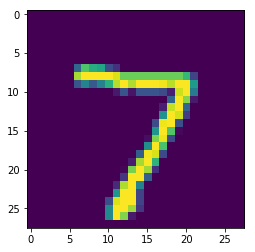

In [11]:
# Select a single image - a batch of 1
testX_1 = testX[0].reshape(1, 784)
print("Model expects this shape data:",testX_1.shape)

# Plot the image
plt.imshow(testX_1[0].reshape(28, 28))

# Make a prediction
predictions = model.predict(testX_1, batch_size=1)
print("\nPredictions are a vector of probabilities:\n", predictions)

# Select index of the highest probability
indx = np.argmax(predictions)
print("\nPredicted digit is", lb.classes_[indx])

Scikit learn comes with a handy function to report useful classification statistics:

In [12]:
from sklearn.metrics import classification_report

# Make predictions
predictions = model.predict(testX, batch_size=128)

# Print a formatted report
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(x) for x in lb.classes_]))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95       460
          1       0.93      0.97      0.95       571
          2       0.91      0.87      0.89       530
          3       0.87      0.89      0.88       500
          4       0.88      0.91      0.89       500
          5       0.85      0.83      0.84       456
          6       0.92      0.90      0.91       462
          7       0.90      0.87      0.88       512
          8       0.88      0.82      0.85       489
          9       0.85      0.86      0.86       520

avg / total       0.89      0.89      0.89      5000



We achieve an average precision of 89 %, which is not bad compared to our random chance of 1/10.

Let's go back and plot some key curves for the training process - loss and accuracy. These were stored in our history object.

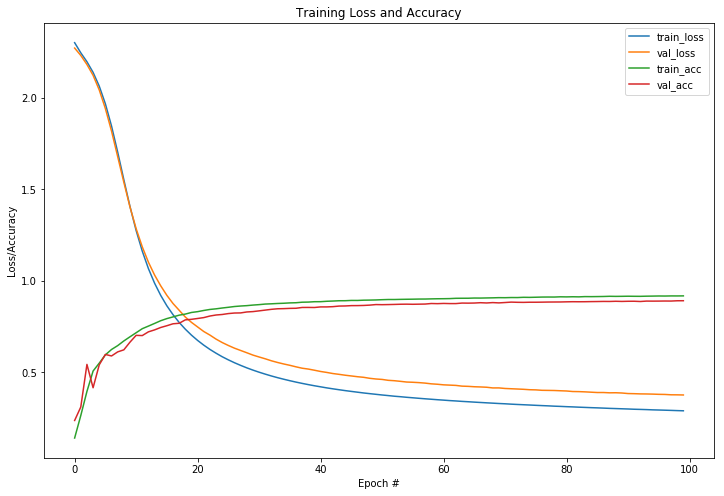

In [14]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()